In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


You should consider upgrading via the 'c:\users\mail2\envs\mlearn\scripts\python.exe -m pip install --upgrade pip' command.


In [58]:
# Import data
insurance_file= "C:/Users/mail2/Envs/mlearn/insurance.csv"
dataset = pd.read_csv(insurance_file)
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [59]:
#check if the dataset contains unknown values
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [60]:
dataset[['children', 'smoker', 'sex','region']].nunique()

children    6
smoker      2
sex         2
region      4
dtype: int64

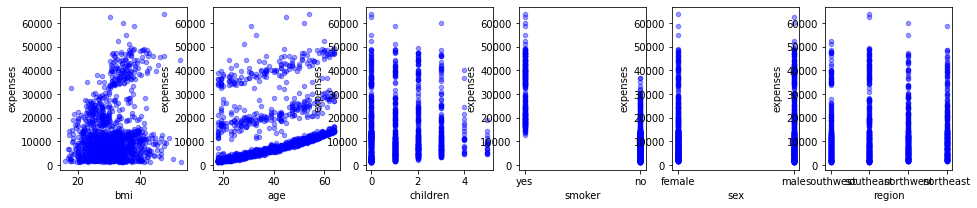

In [4]:
#visualize the data and find the categorical ones
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,3))

for xcol, ax in zip(['bmi','age','children','smoker','sex','region'], axes):
    dataset.plot(kind='scatter', x=xcol, y='expenses', ax=ax, alpha=0.4, color='b')

<AxesSubplot:>

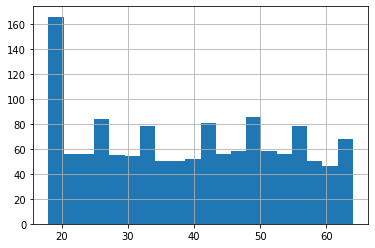

In [55]:
dataset.age.hist(bins=20)

<AxesSubplot:>

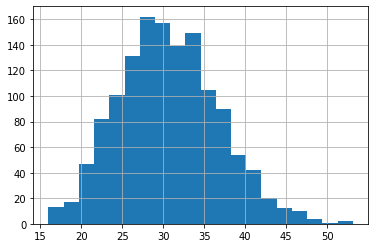

In [6]:
dataset.bmi.hist(bins=20)

<AxesSubplot:>

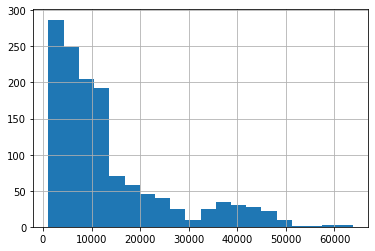

In [7]:
dataset.expenses.hist(bins=20)

<AxesSubplot:>

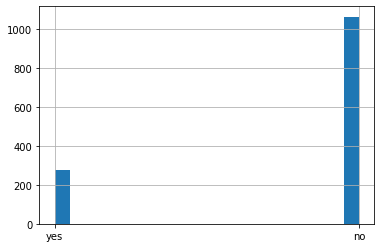

In [8]:
dataset.smoker.hist(bins=20)

In [ ]:
#dataset['sex'] = pd.Categorical(dataset['sex'])
#dataset['sex'] = dataset.sex.cat.codes

In [ ]:
#dataset['smoker'] = pd.Categorical(dataset['smoker'])
#dataset['smoker'] = dataset.smoker.cat.codes
#dataset['region'] = pd.Categorical(dataset['region'])
#dataset['region'] = dataset.region.cat.codes

In [61]:
#creating dummies using one-hot encoding
child_dummies = pd.get_dummies(dataset['children'], prefix='child')
reg_dummies = pd.get_dummies(dataset['region'], prefix='reg',drop_first='True')
gender_dummies = pd.get_dummies(dataset['sex'], prefix='gender')
smoker_dummies = pd.get_dummies(dataset['smoker'], prefix='smoker')
dataset = dataset.drop(['region','sex','smoker'], axis=1)
dataset = pd.concat([dataset, child_dummies, reg_dummies, gender_dummies,smoker_dummies], axis=1)
dataset.head()

,age,bmi,children,expenses,child_0,child_1,child_2,child_3,child_4,child_5,reg_northwest,reg_southeast,reg_southwest,gender_female,gender_male,smoker_no,smoker_yes
0,19,27.9,0,16884.92,1,0,0,0,0,0,0,0,1,1,0,0,1
1,18,33.8,1,1725.55,0,1,0,0,0,0,0,1,0,0,1,1,0
2,28,33.0,3,4449.46,0,0,0,1,0,0,0,1,0,0,1,1,0
3,33,22.7,0,21984.47,1,0,0,0,0,0,1,0,0,0,1,1,0
4,32,28.9,0,3866.86,1,0,0,0,0,0,1,0,0,0,1,1,0


#From the plots it seems, people with no children, the gender and smoker are special features that more significance in determining the expenses. So here I'm trying keep them separate adding additional features to our dataset.

In [62]:
dataset = dataset.drop(['child_1','child_2','child_3','child_4','child_5'], axis=1)

In [63]:
dataset.head()

,age,bmi,children,expenses,child_0,reg_northwest,reg_southeast,reg_southwest,gender_female,gender_male,smoker_no,smoker_yes
0,19,27.9,0,16884.92,1,0,0,1,1,0,0,1
1,18,33.8,1,1725.55,0,0,1,0,0,1,1,0
2,28,33.0,3,4449.46,0,0,1,0,0,1,1,0
3,33,22.7,0,21984.47,1,1,0,0,0,1,1,0
4,32,28.9,0,3866.86,1,1,0,0,0,1,1,0


In [64]:
#data split 80% training and rest test dataset
train_dataset = dataset.sample(frac=0.8, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

In [65]:
#separate features and labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()


train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [56]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
age,39.483178,14.143763
bmi,30.562897,6.076637
children,1.078505,1.205462
child_0,0.439252,0.496528
reg_northwest,0.234579,0.423934
reg_southeast,0.278505,0.448473
reg_southwest,0.244860,0.430205
gender_female,0.510280,0.500128
gender_male,0.489720,0.500128
smoker_no,0.795327,0.403651


In [57]:
test_features.describe().transpose()[['mean', 'std']]

,mean,std
age,38.104478,13.639153
bmi,31.075000,6.178919
children,1.160448,1.205637
child_0,0.388060,0.488220
reg_northwest,0.276119,0.447913
reg_southeast,0.246269,0.431643
reg_southwest,0.235075,0.424839
gender_female,0.432836,0.496395
gender_male,0.567164,0.496395
smoker_no,0.794776,0.404621


In [66]:
#Normalization of the training dataset
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [67]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[19.  35.5  0.   1.   1.   0.   0.   0.   1.   1.   0. ]]

Normalized: [[-1.45  0.81 -0.9   1.13  1.81 -0.62 -0.57 -1.02  1.02  0.51 -0.51]]


In [32]:
#from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(train_features,train_labels)

LinearRegression()

In [36]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

y_prediction = regressor.predict(test_features)
accuracy = accuracy_score(y_true = test_labels.astype(int), y_pred = y_prediction.astype(int))
print('Variance-score (R^2): {0:.4f}'.format(regressor.score(test_features, test_labels)))
print('Mean squared error: {0:.4f}'.format(np.mean((regressor.predict(test_features) - test_labels) ** 2)))
print('Root mean squared error: {0:.4f}'.format(np.sqrt(mean_squared_error(y_true = test_labels, y_pred = y_prediction))))
print('log root mean squared error: {0:.4f}'.format(np.sqrt(np.square(np.log10(y_prediction + 1) - np.log10(test_labels + 1)).mean())))
print('mean absolute error: {0:.4f}'.format(mean_absolute_error(test_labels, y_prediction)))
print('Accuracy: {0:.2f}%'.format(accuracy*100))

Variance-score (R^2): 0.7186
Mean squared error: 44136157.6772
Root mean squared error: 6643.5049
log root mean squared error: 0.2627
mean absolute error: 4556.9209
Accuracy: 0.00%


<ipython-input-36-3fd7b171b9f3>:8: RuntimeWarning: invalid value encountered in log10
  print('log root mean squared error: {0:.4f}'.format(np.sqrt(np.square(np.log10(y_prediction + 1) - np.log10(test_labels + 1)).mean())))


In [68]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=125),
    layers.Dense(units=1)

])

In [69]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=["mae",'mse'])

In [34]:
#train_labels=np.log10(train_labels)

In [70]:

%%time

history = model.fit(
    train_features, train_labels, 
    epochs=10,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/10
27/27 [==============================] - 1s 14ms/step - loss: 13198.2358 - mae: 13198.2358 - mse: 319722813.7143 - val_loss: 12815.1729 - val_mae: 12815.1729 - val_mse: 303556768.0000
Epoch 2/10
27/27 [==============================] - 0s 5ms/step - loss: 11529.6053 - mae: 11529.6053 - mse: 276414777.1429 - val_loss: 8689.3828 - val_mae: 8689.3828 - val_mse: 192611760.0000
Epoch 3/10
27/27 [==============================] - 0s 5ms/step - loss: 6738.2663 - mae: 6738.2663 - mse: 142421402.5714 - val_loss: 3617.9685 - val_mae: 3617.9685 - val_mse: 41804756.0000
Epoch 4/10
27/27 [==============================] - 0s 5ms/step - loss: 3397.4852 - mae: 3397.4852 - mse: 39954941.2143 - val_loss: 3353.1726 - val_mae: 3353.1726 - val_mse: 34672732.0000
Epoch 5/10
27/27 [==============================] - 0s 5ms/step - loss: 3649.8792 - mae: 3649.8792 - mse: 44968883.2857 - val_loss: 3334.1572 - val_mae: 3334.1572 - val_mse: 35922972.0000
Epoch 6/10
27/27 [==============================

In [48]:
model.layers[0].kernel

AttributeError: 'Normalization' object has no attribute 'kernel'

In [65]:
history.history['loss']

[67.00666809082031,
 66.78970336914062,
 66.51739501953125,
 66.24029541015625,
 65.96480560302734,
 65.6885986328125,
 65.41033935546875,
 65.13530731201172,
 64.86038970947266,
 64.5832290649414,
 64.30647277832031,
 64.03167724609375,
 63.75579833984375,
 63.47919845581055,
 63.20166778564453,
 62.92373275756836,
 62.6490364074707,
 62.37267303466797,
 62.0960807800293,
 61.82147216796875,
 61.5443229675293,
 61.268280029296875,
 60.99310302734375,
 60.71635055541992,
 60.44337463378906,
 60.167728424072266,
 59.88897705078125,
 59.614166259765625,
 59.337467193603516,
 59.06450271606445,
 58.78691864013672,
 58.50883483886719,
 58.23389434814453,
 57.95856475830078,
 57.68147659301758,
 57.406620025634766,
 57.13066482543945,
 56.85383987426758,
 56.580326080322266,
 56.30245590209961,
 56.02691650390625,
 55.750465393066406,
 55.47492980957031,
 55.19776916503906,
 54.927330017089844,
 54.64664840698242,
 54.37233352661133,
 54.09647750854492,
 53.818546295166016,
 53.543674468994

In [ ]:
history.history

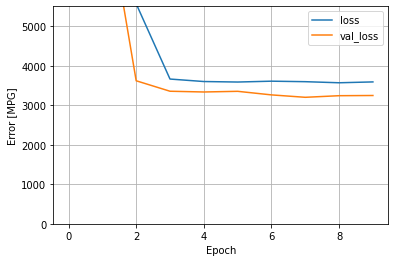

In [71]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5500])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [72]:

loss,mae,mse=model.evaluate(
    test_features,test_labels, verbose=0)
test_dataset=test_features
#test_labels=np.reciprocal(test_labels)

9/9 - 0s - loss: 3401.7817 - mae: 3401.7817 - mse: 41982172.0000
Testing set Mean Abs Error: 3401.78 expenses
You passed the challenge. Great job!


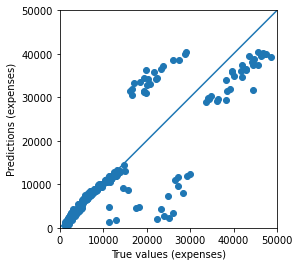

In [73]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
